In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [14]:
REBUILD_DATA = False

In [15]:
class PneumoniaVSNormal():
    IMG_SIZE = 100
    NORMAL = "Pneumonia/chest_xray/train/NORMAL"
    PNEUMONIA = "Pneumonia/chest_xray/train/PNEUMONIA"
    LABELS = {NORMAL : 0, PNEUMONIA : 1}
    training_data = []
    normalCount = 0
    pneumoniaCount = 0
    equalizer = 1341
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    
                    path = os.path.join(label,f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
                    if label == self.NORMAL : 
                        self.normalCount+=1
                    elif label == self.PNEUMONIA: 
                        self.pneumoniaCount+=1
                        if(self.pneumoniaCount == self.equalizer):
                            break
                except Exception as e : 
                    pass
            
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Normal :", self.normalCount)
        print("Pneumonia :", self.pneumoniaCount)
    
if REBUILD_DATA:
    normalpneumonia = PneumoniaVSNormal()
    normalpneumonia.make_training_data()
    

In [16]:
training_data = np.load("training_data.npy", allow_pickle=True)

In [17]:
print(len(training_data))

2682


In [23]:
print(training_data[3])

[array([[ 0,  0,  0, ..., 12,  9,  3],
       [ 0,  0,  0, ..., 13, 11,  2],
       [ 0,  0,  0, ..., 13,  7,  2],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 6,  0,  0, ...,  0,  0,  6]], dtype=uint8)
 array([0., 1.])]


In [19]:
print(training_data[5])

[array([[ 0,  0,  0, ..., 44, 35, 35],
       [ 0,  0,  0, ..., 41, 37, 30],
       [ 0,  0,  0, ..., 41, 34, 27],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)
 array([0., 1.])]


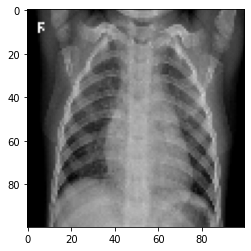

In [25]:
import matplotlib.pyplot as plt
plt.imshow(training_data[5][0], cmap="gray")
plt.show()

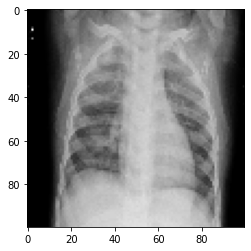

In [24]:
plt.imshow(training_data[3][0], cmap="gray")
plt.show()

In [26]:
#Building the Model + Training it

In [27]:
import torch
import torch.nn as nn 
import torch.nn.functional as F

In [54]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 6)
        
        self.conv2 = nn.Conv2d(32, 32, 6)
        
        self.conv3 = nn.Conv2d(32, 64, 6)
        
        x = torch.randn(100,100).view(-1,1,100,100)
        self._to_linear = None
        self.convs(x)
        self.fc1 = nn.Linear(self._to_linear, 100)
        
        self.fc2 = nn.Linear(100, 2)
        
        
    def convs(self, x):
        x  = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x  = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x  = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        if (self._to_linear is None): 
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2] 
        return x 
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1) 
        
        
        
        

In [55]:
net = Net()

In [56]:
import torch.optim as optim

In [57]:
optimizer  = optim.Adam(net.parameters(), lr=0.0008)
loss_function  = nn.MSELoss()
X = torch.Tensor([i[0] for i in training_data]).view(-1, 100,100)
X = X/255.0

y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.05
VAL_SIZE = int(len(X)*VAL_PCT)



train_X = X[:-VAL_SIZE] 
train_y = y[:-VAL_SIZE]


test_X = X[-VAL_SIZE:]
test_y = y[-VAL_SIZE:]

print(len(train_X))
print(len(test_X))


2548
134


In [58]:
BATCH_SIZE = 50
EPOCHS = 8
for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,100,100)
        batch_y = train_y[i:i+BATCH_SIZE]
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
print(loss)    


100%|███████████████████████████████████████████████████████████████| 51/51 [00:37<00:00,  1.36it/s]

tensor(0.0076, grad_fn=<MseLossBackward>)


In [59]:
correct  = 0
total = 0
with torch.no_grad(): 
    for i in tqdm(range(len(test_X))):
        real  = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1,1,100,100))[0]
        predicted = torch.argmax(net_out)
        if predicted == real : 
            correct += 1 
        total+=1
accuracy = correct / total
accuracy = accuracy * 100
print("accuracy of the model is :", accuracy)        

100%|████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 200.50it/s]

accuracy of the model is : 94.02985074626866


In [63]:
testList = []
img = cv2.imread("332aa0c67cb2e035e372c7cb3ceca2_jumbo.jpg", cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (100, 100))
testList.append([np.array(img)])



TESTIMAGE = torch.Tensor([i[0] for i in testList]).view(-1, 100,100)

out = net(TESTIMAGE[0].view(-1,1,100,100))
prediction = torch.argmax(out)
print(out)

tensor([[0., 1.]], grad_fn=<SoftmaxBackward>)
